In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Hide code."></form>
''')


# Being A Dog Whispering: Inferring pet sentiment using Neural Network dog sound identification


## Background
### Introduction 

Many would like to believe that they understand their pets' nuances and behaviour pattern and great admiration to those who take time to do so. It might be a matter of natural talent or experience. Yet for some, it isnt that inate. What I wanted to do was to teach a machine to have some semblence of this talent in order to support owners to understand their pets and hopefully not misunderstand their signals. 

This exercise isnt about isolating the sound from a dog from a file. That has already been done. Here we try to go to the next step of after isolating the sound we want, we try and take sentiment from it at an albeit rudimentary angle.

However, the application of combining sound data along with perhaps the chemical features of secreted natural pheromones of the animal could possibly lead to a translator for our pets to support owners and enthusiasts alike. Afterall, not everyone can be a dog whisperer.

Future adaptaions could lead to a habitat monitoring system and distress alert system in the wild to address real time human or other unnatural threats to the observed wildlife.

### Main Highlights/Insights

Through this exercise, I have discovered the following.

1. Librosa is an all around Python package for handling sound or wave files.
2. Without trimming the wave files to be the same time lengths could have compromised the accuracy of the systeme despite it being a fairly decent accuracy. 
3. There are those using Neural Network and sound collection for wildlife and habitat monitoring that is found to be cheaper than tracking through imagery. 




### Recommendations and Further Development

1. Increase dataset size for each sentiment classification.
2. Classify the sounds as sentiments as opposed to what the sentiment is associated to the sound.
3. Practice and setting up and fine tuning NN model architecture.

## Methodology

### Data collection

The sound files were requested to be downloaded from https://annotator.freesound.org/fsd/downloads/. They are in the .ogg format and can be listened over Python notebook with the `miniaudio` package using the following commands:  

    stream = ma.stream_file(f'soundfiles/432754_5140792-lq.ogg')  
    device = ma.PlaybackDevice()  
    device.start(stream)  

or from `pydub.AudioSegment` by using:   
   
    AudioSegment.from_ogg(file_name)  


### Data classification

This was a manual step to simulate the instance that the sound files were already identified as from a dog. Each available file was categorized into 
* bark
* howl
* growl
* whimper
* breathe (snoring or panting) 

and the rest that had a mix of human voices or were too muffled to be heard. 

I said it was rudimentary because it was segmented into what sound the dog was making but the sentiment can be as follows and could be tied into more of this at an enhancement of this system: 

<table>
    <thead><tr><th>Bark</th><th>Howl</th><th>Growl</th><th>Whimper</th><th>Breathe</th></tr></thead>
    <tbody>
        <tr><td>There’s someone at the door<br>  
 Your dog is happy to see you  <br>
 Your dog is on guard  <br>
 There’s a threat  </td>
            <td>Separation Anxiety<br>
Sickness<br>
Depression</td>
            <td>Provocation<br>
                Warning of Aggression<br>
                Playing or Rough housng</td>
            <td>Needs the bathroom
Wants a treat or attention<br>
Pain<br>
Excited
            </td>
            <td>Cooling Down<br>
Snoring<br>
Signs of Sickness if Irregular</td>
        </tr>
    </tbody>
</table>

The sentiments of which are based on my personal experience and self proclaimed expertise in being an amateur dog whisperer myself. 


## Library and path setup

Loading of libraries used and the paths to the files...

In [2]:
import miniaudio as ma
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import pylab
from pydub import AudioSegment
from scipy.fftpack import fft
import glob
from tqdm import tqdm_notebook as tqdm

In [83]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
# from keras.utils import to_categorical
from sklearn import metrics 
import tensorflow.keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import random
from sklearn.metrics import confusion_matrix,accuracy_score, precision_recall_fscore_support

In [3]:
soundfiles = os.listdir('soundfiles')
b, h, w, g, br = ('soundfiles/bark', 'soundfiles/howl', 'soundfiles/whimper',
                 'soundfiles/growl','soundfiles/breathe')

In [4]:
barks = glob.glob('soundfiles/bark/*.ogg')#os.listdir(b)
howls = glob.glob('soundfiles/howl/*.ogg')#os.listdir(h)
whimpers = glob.glob('soundfiles/whimper/*.ogg')#os.listdir(w)
growls = glob.glob('soundfiles/growl/*.ogg')#os.listdir(g)
breathes = glob.glob('soundfiles/breathe/*.ogg')#os.listdir(br)


## EDA

Exploratory Data Analysis

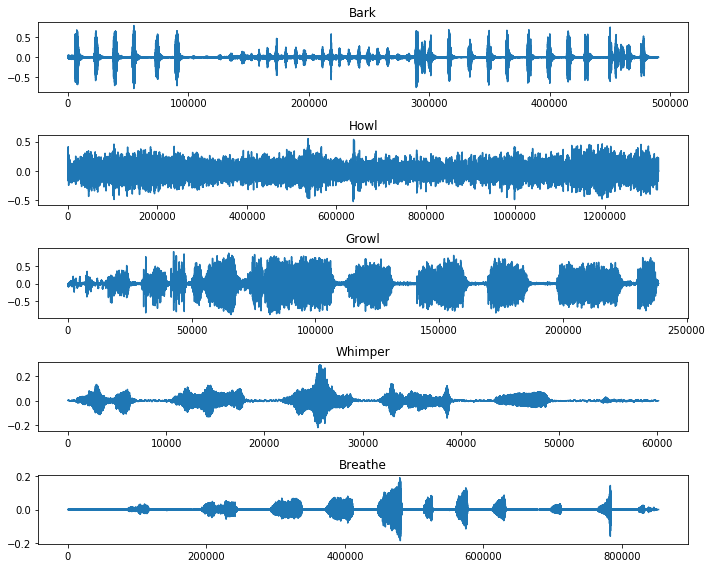

In [10]:
audio0, sample_rate0 = librosa.load(barks[0], res_type='kaiser_fast') 
audio1, sample_rate1 = librosa.load(howls[0], res_type='kaiser_fast') 
audio2, sample_rate2 = librosa.load(growls[0], res_type='kaiser_fast') 
audio3, sample_rate3 = librosa.load(whimpers[0], res_type='kaiser_fast') 
audio4, sample_rate4 = librosa.load(breathes[0], res_type='kaiser_fast') 
fig, ax = plt.subplots(5,1, figsize=(10,8))
ax[0].plot(audio0);
ax[1].plot(audio1);
ax[2].plot(audio2);
ax[3].plot(audio3);
ax[4].plot(audio4);

ax[0].set(title='Bark');
ax[1].set(title='Howl');
ax[2].set(title='Growl');
ax[3].set(title='Whimper');
ax[4].set(title='Breathe');
plt.tight_layout();

Above is what a sample sound files from each of the classification looks like. Clearly, the sample rates or the number of points per second (frequencies) are different.

### Feature Extraction

In order to create our dataset and a few more EDA, we will need to get the raw signal amplitudes of the files, their Fourier Transform equivalent, melspectogram, chroma_stft, chroma_cqt, and chroma_cens as suggested by the people who processed the Urban Sound database.

ref: https://github.com/AmritK10/Urban-Sound-Classification/blob/master/Urban_data_preprocess.ipynb

Hyper parameters used are as follows with the reasoning that they gave better results

In [13]:
def extract_features(filename):
    #load file
    try:
        audio, sample_rate = librosa.load(f'{filename}', res_type='kaiser_fast') 
        if np.max(audio) <= 0.1:
            audio *= 10
        #clip audio to start where not silent and get first 5 second
        start = np.min(np.where(audio > 0.1))
        clip = audio[start:(sample_rate*5)+start]

        #get mfcc features for data frames
        mfccs = np.mean(librosa.feature.mfcc(y=clip, sr=sample_rate, n_mfcc=30).T,axis=0)
        melspectrogram =np.mean(librosa.feature.melspectrogram(y=clip, sr=sample_rate,
                                                       n_mels=30,fmax=8000).T,axis=0)
        chroma_stft=np.mean(librosa.feature.chroma_stft(y=clip, sr=sample_rate,
                                                n_chroma=30).T,axis=0)
        chroma_cq =np.mean(librosa.feature.chroma_cqt(y=clip, sr=sample_rate
                                              ,n_chroma=30).T,axis=0)
        chroma_cens =np.mean(librosa.feature.chroma_cens(y=clip, sr=sample_rate,
                                                 n_chroma=30).T,axis=0)

    except Exception as e:
        print("Error encountered while parsing file: ", filename)
        return None 
#     plt.show()
    fft_out = np.abs(fft(clip[clip>=0]).real)
    features=np.reshape(np.vstack((mfccs,melspectrogram,chroma_stft,
                                   chroma_cq,chroma_cens)),(30,5))
#     return (mfccs,mfccsscaled, fft_out)
    return (features,fft_out)

In [127]:
Xs = []
Xs_fft = []
ys = []

In [128]:
arr2 = [b,h,w,g,br]
types = ['bark', 'howl','whimper','growl','breathe']
for i, arr in enumerate([barks, howls, whimpers, growls, breathes]):
    print(f'Processing {types[i]}...')
    with tqdm(total=len(arr)) as pbar:
    #     for i in range(len(barks)):
        for f in arr:
            Xs.append(extract_features(f)[0])
            Xs_fft.append(extract_features(f)[1])
            ys.append(types[i])
            pbar.update(1)

#     features.append([feats, label])

Processing bark...



Processing howl...



Processing whimper...


C:\Users\User\Anaconda3\lib\site-packages\librosa\core\pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')



Processing growl...



Processing breathe...


Naturally, as this is a classification problem, we calculate for the PCC as shown below. 

Population per class:            0
bark     157
howl      49
whimper   65
growl     74
breathe   44

1.25 * Proportion Chance Criterion: 31.957725629621798%


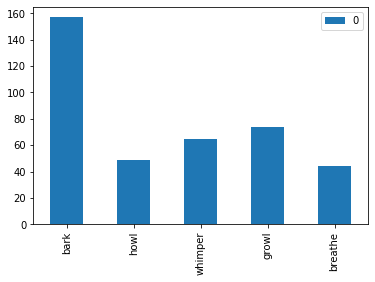

In [130]:
from collections import Counter
targets = Counter(np.array(ys))
# salary_counts
df_targets = pd.DataFrame.from_dict( targets, orient='index')
# df_targets.index = ['<= 50K', '>50k']
df_targets.plot(kind='bar')

num=(df_targets[0]/df_targets[0].sum())**2
print("Population per class: {}\n".format(df_targets))
print("1.25 * Proportion Chance Criterion: {}%".format(1.25*100*num.sum()))

In [352]:
audio, sample_rate = librosa.load(barks[0], res_type='kaiser_fast') 
if np.max(audio) <= 0.1:
    audio *= 10
#clip audio to start where not silent and get first 5 second
start = np.min(np.where(audio > 0.1))
clip = audio[start:(sample_rate*5)+start]
mfccs = librosa.feature.mfcc(y=clip, sr=sample_rate, n_mfcc=30)
melspectrogram = librosa.feature.melspectrogram(y=clip, sr=sample_rate,
                                               n_mels=30,fmax=8000)
chroma_stft = librosa.feature.chroma_stft(y=clip, sr=sample_rate,
                                        n_chroma=30)
chroma_cq = librosa.feature.chroma_cqt(y=clip, sr=sample_rate
                                      ,n_chroma=30)
chroma_cens = librosa.feature.chroma_cens(y=clip, sr=sample_rate,
                                         n_chroma=30)

The following 5 graph below shows corresponding visualizations of the features we extracted above. What they mean can be found in the 'Terms Used' section.

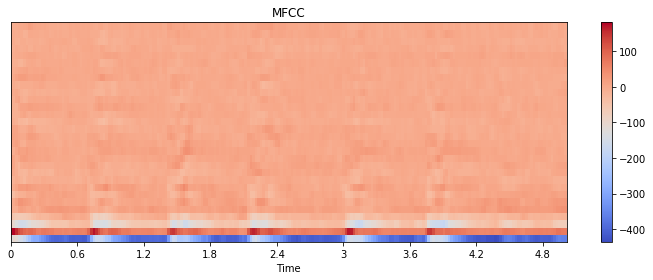

In [356]:
plt.figure(figsize=(10,4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

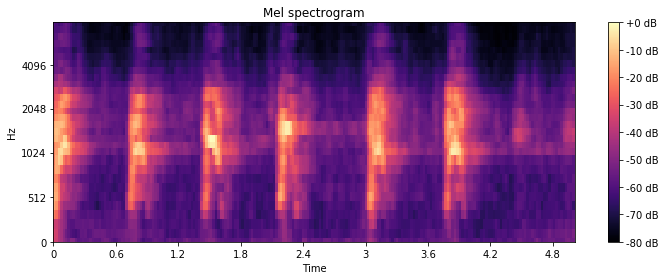

In [357]:
plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.power_to_db(melspectrogram,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

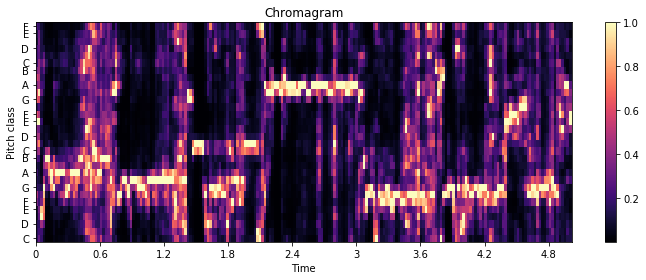

In [358]:
plt.figure(figsize=(10,4))
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

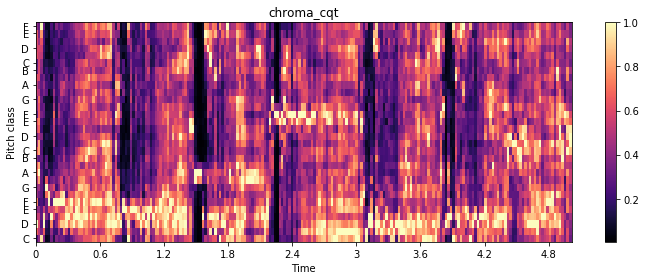

In [359]:
plt.figure(figsize=(10,4))
librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('chroma_cqt')
plt.tight_layout()

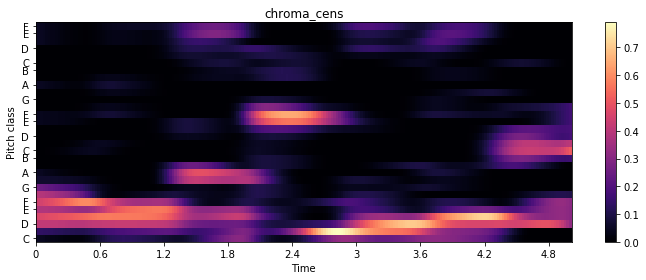

In [360]:
plt.figure(figsize=(10,4))
librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('chroma_cens')
plt.tight_layout()

## Modeling

I will be attempting to do 3 models here. First will be the ANN of just the mfcc signal of the files. The second will be the ANN of the Fourier Transform of the sounds, and last will be a CNN approach using the melspectogram, chroma_stft, chroma_cqt, and chroma_cens features. 


The features hae been scaled with sklearn's MinMaxScaler for better results.

In [133]:
X_.shape
y_.shape

(292,)

In [237]:
# tranform collected features and labels to arrays
X_ = np.array(Xs)
y_ = np.array(ys)
Xfft_ = np.array(Xs_fft)



### CNN of melspectogram, chroma_stft, chroma_cqt, and chroma_cens features. 


In [238]:
# reshape X
X2 =  np.reshape(X_,(X_.shape[0],X_.shape[1]*X_.shape[2]))

In [239]:
le = LabelEncoder()
y2 = to_categorical(le.fit_transform(y_))

In [296]:
#scale X2
scaler = MinMaxScaler()
XX = scaler.fit_transform(X2)
X_train, X_test, y_train, y_test = train_test_split(
    XX, y2, test_size=0.2, random_state=42)

In [297]:
X_train=np.reshape(X_train,(X_train.shape[0], 30,5,1))
X_test=np.reshape(X_test,(X_test.shape[0], 30,5,1))

In [298]:
model=Sequential()
model.add(Conv2D(256,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(30,5,1)))
model.add(MaxPooling2D(padding="same"))

model.add(Flatten())
model.add(Dense(64,activation="relu"))
# model.add(Dropout(0.5))
model.add(Dense(64,activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(5,activation="softmax"))
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])


The structure of the model, at least the best I could, has the following architecture.

In [299]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 30, 5, 256)        6656      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 15, 3, 256)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 11520)             0         
_________________________________________________________________
dense_86 (Dense)             (None, 64)                737344    
_________________________________________________________________
dense_87 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_88 (Dense)             (None, 5)               

In [304]:
history = model.fit(
    X_train,y_train, 
    epochs=100,
#     validation_split=0.2,
    validation_data=(X_test,y_test),
    verbose=2
)

Train on 311 samples, validate on 78 samples
Epoch 1/100
311/311 - 1s - loss: 0.0723 - acc: 0.9904 - val_loss: 1.2167 - val_acc: 0.6410
Epoch 2/100
311/311 - 0s - loss: 0.0605 - acc: 1.0000 - val_loss: 1.2704 - val_acc: 0.6667
Epoch 3/100
311/311 - 0s - loss: 0.0612 - acc: 0.9904 - val_loss: 1.2806 - val_acc: 0.6923
Epoch 4/100
311/311 - 0s - loss: 0.0585 - acc: 0.9904 - val_loss: 1.2623 - val_acc: 0.7051
Epoch 5/100
311/311 - 0s - loss: 0.0650 - acc: 0.9936 - val_loss: 1.3050 - val_acc: 0.6667
Epoch 6/100
311/311 - 0s - loss: 0.0622 - acc: 0.9871 - val_loss: 1.4586 - val_acc: 0.6410
Epoch 7/100
311/311 - 0s - loss: 0.0488 - acc: 0.9904 - val_loss: 1.2243 - val_acc: 0.6538
Epoch 8/100
311/311 - 0s - loss: 0.0435 - acc: 0.9968 - val_loss: 1.3290 - val_acc: 0.6795
Epoch 9/100
311/311 - 0s - loss: 0.0411 - acc: 0.9936 - val_loss: 1.5731 - val_acc: 0.6538
Epoch 10/100
311/311 - 0s - loss: 0.0504 - acc: 0.9936 - val_loss: 1.3772 - val_acc: 0.6667
Epoch 11/100
311/311 - 0s - loss: 0.0389 - a

Epoch 90/100
311/311 - 0s - loss: 0.0090 - acc: 0.9968 - val_loss: 1.8568 - val_acc: 0.6667
Epoch 91/100
311/311 - 0s - loss: 0.0071 - acc: 1.0000 - val_loss: 1.8626 - val_acc: 0.6795
Epoch 92/100
311/311 - 0s - loss: 0.0138 - acc: 0.9936 - val_loss: 1.7780 - val_acc: 0.6667
Epoch 93/100
311/311 - 0s - loss: 0.0103 - acc: 0.9936 - val_loss: 1.7651 - val_acc: 0.6923
Epoch 94/100
311/311 - 0s - loss: 0.0109 - acc: 0.9936 - val_loss: 1.8454 - val_acc: 0.6667
Epoch 95/100
311/311 - 0s - loss: 0.0111 - acc: 0.9936 - val_loss: 1.8175 - val_acc: 0.6795
Epoch 96/100
311/311 - 0s - loss: 0.0108 - acc: 0.9936 - val_loss: 1.7034 - val_acc: 0.6923
Epoch 97/100
311/311 - 0s - loss: 0.0095 - acc: 0.9968 - val_loss: 1.9287 - val_acc: 0.6667
Epoch 98/100
311/311 - 0s - loss: 0.0081 - acc: 0.9968 - val_loss: 1.8476 - val_acc: 0.6923
Epoch 99/100
311/311 - 0s - loss: 0.0122 - acc: 0.9968 - val_loss: 1.8265 - val_acc: 0.6923
Epoch 100/100
311/311 - 0s - loss: 0.0145 - acc: 0.9936 - val_loss: 1.7634 - val

In [305]:
train_loss_score=model.evaluate(X_train,y_train);
test_loss_score=model.evaluate(X_test,y_test);

78/78 [==============================] - ETA: 0s - loss: 2.0100 - acc: 0.687 - 0s 245us/sample - loss: 1.7634 - acc: 0.6923


In [306]:
print(train_loss_score)
print(test_loss_score)

[0.00570446626400018, 0.99678457]
[1.7634465938959367, 0.6923077]


With the CNN model used, the test accuracy was able to achieve 69.23%. Below is a recall and precision summary.


In [169]:
y_true, y_pred = y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1)
pr = pd.DataFrame(precision_recall_fscore_support(y_true, y_pred)).T
pr.columns=['Precision','Recall','F1','Support']
pr

,Precision,Recall,F1,Support
0,0.823529,0.700000,0.756757,20.0
1,0.400000,0.666667,0.500000,6.0
2,1.000000,0.666667,0.800000,6.0
3,1.000000,0.800000,0.888889,5.0
4,0.000000,0.000000,0.000000,2.0


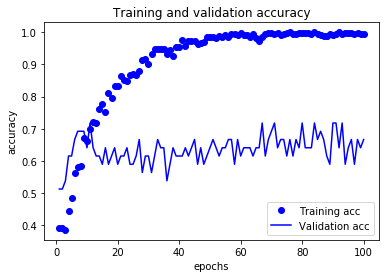

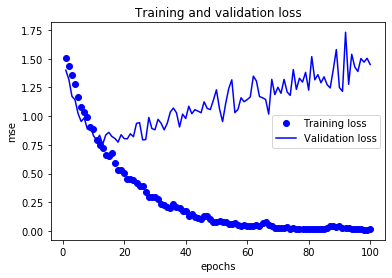

In [170]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()

plt.show()

The plots above show the general accuracies and losses achieved by the model. 69% clearly beats our PCC fairly enough.


### ANN of Fourier Transform. 

For this, we will only be looking at the FFT form of the wave much like below. We will only take those above 0 Hz of course as they are more or less symmetrical.

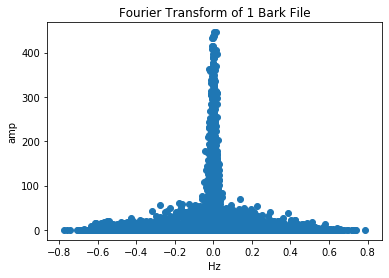

In [192]:

fig, ax = plt.subplots();
ax.scatter(clip, np.abs(fft(clip).real));
ax.set(xlabel='Hz', ylabel='amp', title='Fourier Transform of 1 Bark File');


# X152[0]

In [242]:
dfft = pd.DataFrame(Xfft_).replace(np.nan,0)

In [315]:
X152.head()

,0,1,2,3,4,5,6,7,8,9,...,78946,78947,78948,78949,78950,78951,78952,78953,78954,78955
0,2040.100830,114.108414,131.496506,270.227844,359.245087,385.001984,339.691589,388.337494,119.091232,396.074005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,829.821228,123.020302,446.835999,381.373718,75.823395,551.565918,42.247292,218.909424,205.318924,6.997322,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3370.673828,565.152100,252.719604,41.663155,119.599297,112.471169,171.640427,77.550934,114.269997,178.516479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4440.445312,389.578247,170.104156,83.187164,76.801033,53.998947,106.398643,13.493404,31.873238,174.861359,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3224.777344,0.766317,604.896606,238.401031,33.980309,271.916595,2.507499,327.220276,44.980755,147.979874,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [316]:
X152 = pd.DataFrame([x for x in dfft[0].values.tolist()]).replace(np.nan,0)
XX152 = scaler.fit_transform(X152.values)
X_train, X_test, y_train, y_test = train_test_split(
    X152, y2, test_size=0.2, random_state=42)

In [317]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,78946,78947,78948,78949,78950,78951,78952,78953,78954,78955
271,6874.008789,539.979248,316.963318,910.903259,30.637449,507.478210,489.893219,285.811676,487.936646,216.913620,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
46,129.036667,80.419991,15.116483,24.465681,35.718296,25.771618,8.305786,0.996774,0.573666,4.810672,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
167,1838.282593,114.203346,42.743671,182.222427,62.346020,55.979870,103.449951,86.831757,89.865349,119.540779,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
42,2958.566895,100.323631,68.719330,80.017586,71.523727,32.585526,26.922085,128.219498,25.621233,7.682560,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
350,2278.597656,369.270935,192.322540,132.516220,24.816008,312.314850,186.729126,129.752518,5.675796,51.852985,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
181,7702.611816,1221.319580,844.201599,232.085617,255.569611,181.302200,511.618591,363.309662,161.863419,248.568695,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
153,1597.261108,40.578381,608.771790,441.491150,221.047195,173.202606,50.944218,107.832947,63.480850,209.838593,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
33,799.608215,23.771851,226.947327,131.716553,23.279470,246.469955,73.060806,195.281830,54.006035,45.092823,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
116,367.913910,200.373230,200.994812,338.051422,168.940125,178.779755,295.381439,132.544617,164.097488,267.322937,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
148,5842.909180,555.522949,98.879829,335.303467,1201.410400,158.441162,135.169052,712.476685,565.760071,7.676311,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [333]:
model = Sequential([
#     Flatten(),
    Dense(512,input_dim=X152.shape[-1],  activation='relu'),#
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
#     Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(5, activation='softmax')
])

The ANN model for the FFT waves will have the following architecture.

In [327]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 512)               40425984  
_________________________________________________________________
dense_96 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_97 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_98 (Dense)             (None, 5)                 645       
Total params: 40,508,805
Trainable params: 40,508,805
Non-trainable params: 0
_________________________________________________________________


In [328]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [329]:
history = model.fit(
    X_train,y_train, 
    epochs=50,
#     validation_split=0.2,
    validation_data=(X_test,y_test),
    verbose=2
)

Train on 311 samples, validate on 78 samples
Epoch 1/50
311/311 - 5s - loss: 90.3222 - acc: 0.2476 - val_loss: 50.7803 - val_acc: 0.2051
Epoch 2/50
311/311 - 2s - loss: 27.1612 - acc: 0.3859 - val_loss: 26.9446 - val_acc: 0.2179
Epoch 3/50
311/311 - 2s - loss: 8.3445 - acc: 0.6431 - val_loss: 15.7257 - val_acc: 0.5513
Epoch 4/50
311/311 - 3s - loss: 8.1552 - acc: 0.6720 - val_loss: 25.6700 - val_acc: 0.4744
Epoch 5/50
311/311 - 3s - loss: 6.1294 - acc: 0.6688 - val_loss: 25.5575 - val_acc: 0.5000
Epoch 6/50
311/311 - 3s - loss: 6.7911 - acc: 0.7428 - val_loss: 20.3628 - val_acc: 0.4744
Epoch 7/50
311/311 - 2s - loss: 1.3536 - acc: 0.9035 - val_loss: 23.2784 - val_acc: 0.3718
Epoch 8/50
311/311 - 2s - loss: 0.8369 - acc: 0.9003 - val_loss: 18.1740 - val_acc: 0.5256
Epoch 9/50
311/311 - 3s - loss: 0.9183 - acc: 0.9068 - val_loss: 30.9087 - val_acc: 0.3205
Epoch 10/50
311/311 - 3s - loss: 0.5655 - acc: 0.9421 - val_loss: 21.5189 - val_acc: 0.4744
Epoch 11/50
311/311 - 3s - loss: 0.8023 - 

In [330]:
train_loss_score=model.evaluate(X_train,y_train);
test_loss_score=model.evaluate(X_test,y_test);

78/78 [==============================] - ETA: 0s - loss: 31.3044 - acc: 0.46 - ETA: 0s - loss: 21.2370 - acc: 0.45 - 0s 3ms/sample - loss: 22.2506 - acc: 0.4487


In [331]:
print(train_loss_score)
print(test_loss_score)

[0.6396046841307094, 0.99678457]
[22.250626392853565, 0.44871795]


### ANN of the Mfcc

For this ANN, we will just look at the Mfcc signal of the sound waves.

In [387]:
X_mfcc = [x[0] for x in Xs]

In [428]:
[x[0] for x in Xs]

[array([-334.85611758,   76.75366303,  -76.99373915,  -28.45838819,
          14.48016013]),
 array([-513.343551  ,   67.23477547,   20.79529961,    6.73219416,
           1.84587038]),
 array([-158.96243385,   97.31101511,   -2.24919442,   11.7069017 ,
         -10.57581407]),
 array([-166.25541876,   77.43272571,  -18.3320764 ,   44.98255316,
           4.02561823]),
 array([-251.93032695,  119.67397745,  -52.02441324,   -6.77161064,
           4.0729868 ]),
 array([-264.92085881,  139.0561121 ,  -73.16856599,  -56.19616778,
          -3.00473108]),
 array([-361.71568132,  106.804093  ,  -26.12135948,   -4.49582535,
         -19.17296312]),
 array([-401.20873164,   88.12510864,  -30.06251592,  -20.27929184,
          -4.1496861 ]),
 array([-367.33012282,   76.01508475,  -10.2974158 ,  -25.52787874,
         -25.47621329]),
 array([-234.35039571,   75.52238235,  -34.48590409,    3.03823167,
         -13.06404058]),
 array([-422.43623558,   81.02864364,  -52.13455017,  -25.90505394,
  

In [563]:
dfs = pd.DataFrame(X_mfcc)
hdf = dfs.iloc[:157].sample(60)
# hdf.index
dfs2= pd.concat([hdf, dfs.iloc[157:]])
# dfs2.index
y3 = [yy.tolist() for iy,yy in enumerate(y2) if iy in dfs2.index]

In [566]:
y2
y3_ = np.array(y3)
y3_

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [554]:
X153 = dfs2.values

In [638]:
scaler = MinMaxScaler()
XX153 = scaler.fit_transform(X153)
X_train, X_test, y_train, y_test = train_test_split(
    XX153, y3_, test_size=0.25, random_state=42)

In [670]:
model = Sequential([
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dense(128, activation='relu'), #61
#     Dense(64, activation='relu'),
    Dense(64, activation='relu'),
#     Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.2),


#     Dense(64, activation='relu'),
#     Dense(64, activation='relu'),
# #     Dense(32, activation='relu'),
#     Dropout(0.3), #70.51%
    
Dense(5, activation='softmax'),

])
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


In [671]:
history = model.fit(
    X_train,y_train, 
    epochs=100,
#     validation_split=0.2,
    validation_data=(X_test,y_test),
    verbose=2
)

Train on 219 samples, validate on 73 samples
Epoch 1/100
219/219 - 5s - loss: 1.6333 - acc: 0.1370 - val_loss: 1.6097 - val_acc: 0.1644
Epoch 2/100
219/219 - 0s - loss: 1.6077 - acc: 0.2192 - val_loss: 1.5979 - val_acc: 0.2466
Epoch 3/100
219/219 - 0s - loss: 1.5994 - acc: 0.2648 - val_loss: 1.5897 - val_acc: 0.2055
Epoch 4/100
219/219 - 0s - loss: 1.5755 - acc: 0.2694 - val_loss: 1.5845 - val_acc: 0.2055
Epoch 5/100
219/219 - 0s - loss: 1.5664 - acc: 0.2831 - val_loss: 1.5787 - val_acc: 0.2055
Epoch 6/100
219/219 - 0s - loss: 1.5551 - acc: 0.2785 - val_loss: 1.5721 - val_acc: 0.2055
Epoch 7/100
219/219 - 0s - loss: 1.5453 - acc: 0.2694 - val_loss: 1.5651 - val_acc: 0.2055
Epoch 8/100
219/219 - 0s - loss: 1.5506 - acc: 0.2648 - val_loss: 1.5544 - val_acc: 0.2055
Epoch 9/100
219/219 - 0s - loss: 1.5294 - acc: 0.2785 - val_loss: 1.5435 - val_acc: 0.2055
Epoch 10/100
219/219 - 0s - loss: 1.5163 - acc: 0.3014 - val_loss: 1.5310 - val_acc: 0.2192
Epoch 11/100
219/219 - 0s - loss: 1.5092 - a

Epoch 90/100
219/219 - 0s - loss: 1.1294 - acc: 0.5434 - val_loss: 1.2719 - val_acc: 0.5616
Epoch 91/100
219/219 - 0s - loss: 1.1157 - acc: 0.5753 - val_loss: 1.2733 - val_acc: 0.5616
Epoch 92/100
219/219 - 0s - loss: 1.1357 - acc: 0.5388 - val_loss: 1.2811 - val_acc: 0.5616
Epoch 93/100
219/219 - 0s - loss: 1.1441 - acc: 0.5571 - val_loss: 1.2730 - val_acc: 0.5616
Epoch 94/100
219/219 - 0s - loss: 1.1205 - acc: 0.5753 - val_loss: 1.2700 - val_acc: 0.5479
Epoch 95/100
219/219 - 0s - loss: 1.1391 - acc: 0.5388 - val_loss: 1.2704 - val_acc: 0.5616
Epoch 96/100
219/219 - 0s - loss: 1.1322 - acc: 0.5753 - val_loss: 1.2712 - val_acc: 0.5753
Epoch 97/100
219/219 - 0s - loss: 1.1238 - acc: 0.5616 - val_loss: 1.2698 - val_acc: 0.5616
Epoch 98/100
219/219 - 0s - loss: 1.1384 - acc: 0.5342 - val_loss: 1.2687 - val_acc: 0.5616
Epoch 99/100
219/219 - 0s - loss: 1.1245 - acc: 0.5799 - val_loss: 1.2628 - val_acc: 0.5753
Epoch 100/100
219/219 - 0s - loss: 1.1268 - acc: 0.5708 - val_loss: 1.2622 - val

In [672]:
train_loss_score=model.evaluate(X_train,y_train);
test_loss_score=model.evaluate(X_test,y_test);

73/73 [==============================] - ETA: 0s - loss: 1.1743 - acc: 0.593 - 0s 436us/sample - loss: 1.2622 - acc: 0.5616


In [673]:
print(train_loss_score)
print(test_loss_score)

[1.0970517315276682, 0.5890411]
[1.2621502745641422, 0.56164384]


From above, the test seems to only reach 56.16% but in another notebook where the cell below was copied from, I did manage to get a 71.79% test accuracy and a train accuracy of 75.57%. Despite replicating the model, I could not manage to replicate the results. I wish I could further develop this and time to collect more samples with better model architecture.

In [976]:
# y_true, y_pred = y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1)

0.717948717948718

# Terms Used


1. Mfcc
    - transforms the sound into a the pitch domain of the human range
2. Melspectogram
    - transforms the sound wave into the pitch domain 
3. Chromagram 
    - contains the musical notation contained in the sound file.
4. Chromagram CQT (Constant Q Transform)
    - similar to the Fourier Transform, it transformes the sound file into the frequency domain.
5. Chromagram CEN (Chromo Energy Normalized Statistics)
    - normalizes the deviations of the chromagram of the sound file.
    

# Acknowledgements

1. Prof Chris for introducing Neural Network
2. Ed David, Jr and Pat Manasan for sharing their experience
3. https://github.com/AmritK10/Urban-Sound-Classification/blob/master/Urban_data_preprocess.ipynb 
4. https://medium.com/coinmonks/automated-animal-identification-using-deep-learning-techniques-41039f2a994d